# Nipype Showcase

What's all the hype about Nipype? Is it really that good? Short answer: Yes!

Long answer: ... well, let's consider a very simple fMRI preprocessing workflow that just performs:
1. slice time correction
2. motion correction
3. smoothing

# Preparing the preprocessing workflow

First, we need to import the main Nipype tools: `Node` and `Workflow`

In [1]:
from nipype import Node, Workflow

Now, we can import the interfaces that we want to use for the preprocessing.

In [2]:
from nipype.interfaces.fsl import SliceTimer, MCFLIRT, Smooth

Next, we will put the three interfaces into a node and define the specific input parameters.

In [3]:
# Initiate a node to correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             time_repetition=2.5),
                  name="slicetimer")

In [4]:
# Initiate a node to correct for motion
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name="mcflirt")

In [5]:
# Initiate a node to smooth functional images
smooth = Node(Smooth(fwhm=4), name="smooth")

After creating the nodes, we can now create the preprocessing workflow.

In [6]:
preproc01 = Workflow(name='preproc01', base_dir='.')

Now, we can put all the nodes into this preprocessing workflow. We specify the data flow / execution flow of the workflow by connecting the corresponding nodes to each other.

In [7]:
preproc01.connect([(slicetimer, mcflirt, [('slice_time_corrected_file', 'in_file')]),
                   (mcflirt, smooth, [('out_file', 'in_file')])])

To better understand what we did we can write out the workflow graph and visualize it directly in this notebook.

In [8]:
preproc01.write_graph(graph2use='orig')

211017-18:13:04,666 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/workshop_weizmann/workshop/nipype/notebooks/preproc01/graph.png (graph2use=orig, simple_form=True).


'/home/neuro/workshop_weizmann/workshop/nipype/notebooks/preproc01/graph.png'

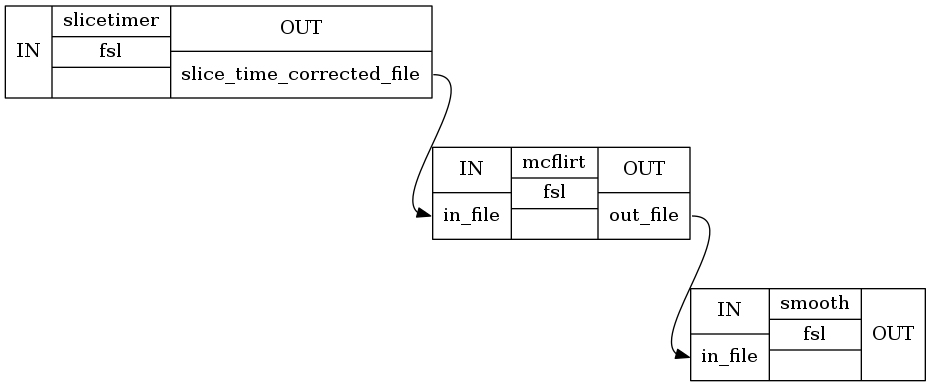

In [9]:
# Visualize graph
from IPython.display import Image
Image(filename="preproc01/graph_detailed.png")

# Run the workflow on one functional image

Now, that we've created a workflow, let's run it on a functional image.

For this, we first need to specify the input file of the very first node, i.e. the `slicetimer` node.

In [10]:
slicetimer.inputs.in_file = '/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz'

To show off Nipype's parallelization power, let's run the workflow in parallel, on 5 processors and let's show the execution time:

In [11]:
%time preproc01.run('MultiProc', plugin_args={'n_procs': 5})

211017-18:13:04,745 nipype.workflow INFO:
	 Workflow preproc01 settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:13:04,775 nipype.workflow INFO:
	 Running in parallel.
211017-18:13:04,779 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 1.75/1.75, Free processors: 5/5.
211017-18:13:04,860 nipype.workflow INFO:
	 [Node] Setting-up "preproc01.slicetimer" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/preproc01/slicetimer".
211017-18:13:04,894 nipype.workflow INFO:
	 [Node] Running "slicetimer" ("nipype.interfaces.fsl.preprocess.SliceTimer"), a CommandLine Interface with command:
slicetimer --in=/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz --odd --out=/home/neuro/workshop_weizmann/workshop/nipype/notebooks/preproc01/slicetimer/sub-01_ses-test_task-fingerfootlips_bold_st.nii.gz --repeat=2.500000
211017-18:13:06,783 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs rea

## Conclusion

Nice, the whole execution took ~2min. But wait... The parallelization didn't really help.

That's true, but because there was no possibility to run the workflow in parallel. Each node depends on the output of the previous node.

# Results of `preproc01`

So, what did we get? Let's look at the output folder `preproc01`:

In [12]:
!tree preproc01 -I '*js|*json|*pklz|_report|*.dot|*html'

preproc01
├── graph_detailed.png
├── graph.png
├── mcflirt
│   ├── command.txt
│   └── sub-01_ses-test_task-fingerfootlips_bold_st_mcf.nii.gz
├── slicetimer
│   ├── command.txt
│   └── sub-01_ses-test_task-fingerfootlips_bold_st.nii.gz
└── smooth
    ├── command.txt
    └── sub-01_ses-test_task-fingerfootlips_bold_st_mcf_smooth.nii.gz

3 directories, 8 files


# Rerunning of a workflow

Now, for fun. Let's run the workflow again, but let's change the `fwhm` value of the Gaussian smoothing kernel to `2`.

In [13]:
smooth.inputs.fwhm = 2

And let's run the workflow again.

In [14]:
%time preproc01.run('MultiProc', plugin_args={'n_procs': 5})

211017-18:14:55,793 nipype.workflow INFO:
	 Workflow preproc01 settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:14:55,844 nipype.workflow INFO:
	 Running in parallel.
211017-18:14:55,848 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 1.75/1.75, Free processors: 5/5.
211017-18:14:55,908 nipype.workflow INFO:
	 [Job 0] Cached (preproc01.slicetimer).
211017-18:14:57,927 nipype.workflow INFO:
	 [Job 1] Cached (preproc01.mcflirt).
211017-18:14:59,933 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc01.smooth".
211017-18:14:59,978 nipype.workflow INFO:
	 [Node] Setting-up "preproc01.smooth" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/preproc01/smooth".
211017-18:14:59,989 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc01.smooth".
211017-18:15:00,64 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /ho

## Conclusion

Interesting, now it only took ~15s to execute the whole workflow again. **What happened?**

As you can see from the log above, Nipype didn't execute the two nodes `slicetimer` and `mclfirt` again. This, because their input values didn't change from the last execution. The `preproc01` workflow therefore only had to rerun the node `smooth`.

# Running a workflow in parallel

Ok, ok... Rerunning a workflow again is faster. That's nice and all, but I want more. **You spoke of parallel execution!**

We saw that the `preproc01` workflow takes about ~2min to execute completely. So, if we would run the workflow on five functional images, it should take about ~10min total. This, of course, assuming the execution will be done sequentially. Now, let's see how long it takes if we run it in parallel.

In [15]:
# First, let's copy/clone 'preproc01'
preproc02 = preproc01.clone('preproc02')
preproc03 = preproc01.clone('preproc03')
preproc04 = preproc01.clone('preproc04')
preproc05 = preproc01.clone('preproc05')

We now have five different preprocessing workflows. If we want to run them in parallel, we can put them all in another workflow.

In [16]:
metaflow = Workflow(name='metaflow', base_dir='.')

In [17]:
# Now we can add the five preproc workflows to the bigger metaflow
metaflow.add_nodes([preproc01, preproc02, preproc03,
                    preproc04, preproc05])

**Note:** We now have a workflow (`metaflow`), that contains five other workflows (`preproc0?`), each of them containing three nodes.

To better understand this, let's visualize this `metaflow`.

In [18]:
# As before, let's write the graph of the workflow
metaflow.write_graph(graph2use='flat')

211017-18:15:14,299 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/workshop_weizmann/workshop/nipype/notebooks/metaflow/graph.png (graph2use=flat, simple_form=True).


'/home/neuro/workshop_weizmann/workshop/nipype/notebooks/metaflow/graph.png'

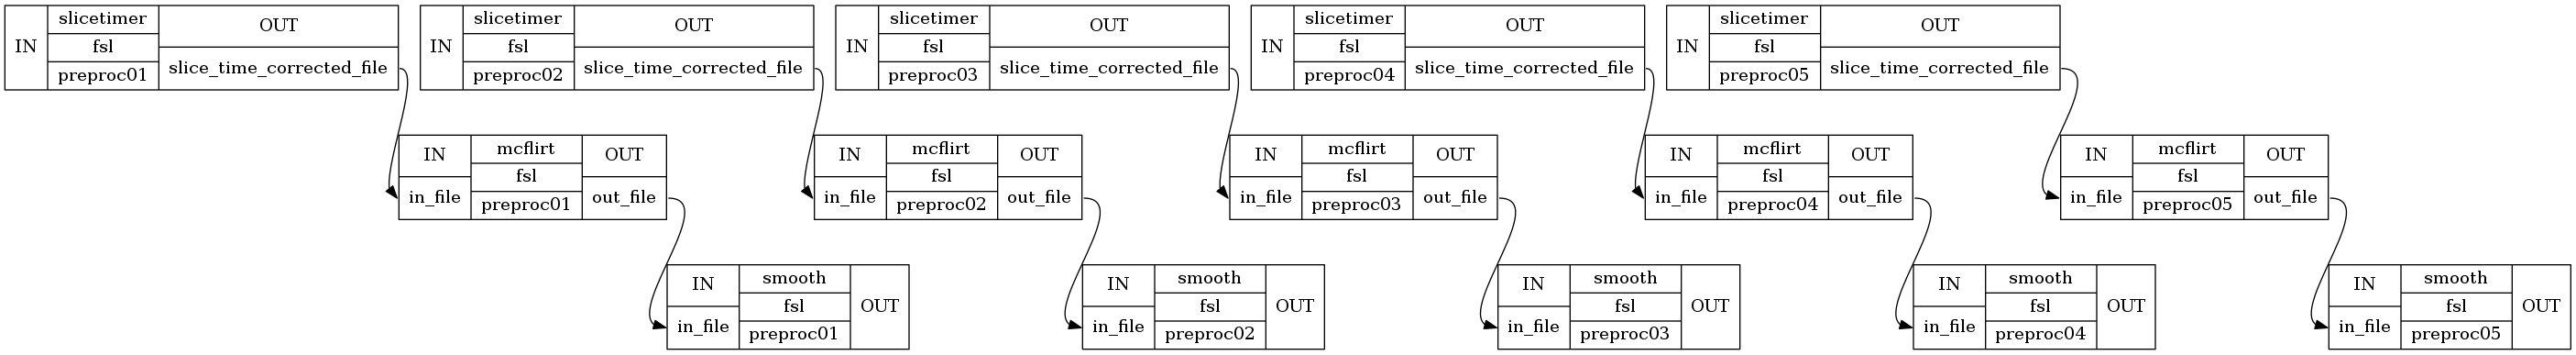

In [19]:
# And visualize the graph
from IPython.display import Image
Image(filename="metaflow/graph_detailed.png")

Ah... so now we can see that the `metaflow` has potential for parallelization. So let's put it to test

In [20]:
%time metaflow.run('MultiProc', plugin_args={'n_procs': 5})

211017-18:15:14,337 nipype.workflow INFO:
	 Workflow metaflow settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:15:14,368 nipype.workflow INFO:
	 Running in parallel.
211017-18:15:14,372 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 1.75/1.75, Free processors: 5/5.
211017-18:15:14,443 nipype.workflow INFO:
	 [Node] Setting-up "metaflow.preproc02.slicetimer" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/metaflow/preproc02/slicetimer".
211017-18:15:14,440 nipype.workflow INFO:
	 [Node] Setting-up "metaflow.preproc01.slicetimer" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/metaflow/preproc01/slicetimer".
211017-18:15:14,444 nipype.workflow INFO:
	 [Node] Setting-up "metaflow.preproc03.slicetimer" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/metaflow/preproc03/slicetimer".
211017-18:15:14,451 nipype.workflow INFO:
	 [Node] Setting-up "metaflow.preproc05.slicetimer" in "/home/neuro/works

211017-18:18:17,924 nipype.workflow INFO:
	 [Node] Finished "metaflow.preproc01.mcflirt".
211017-18:18:18,421 nipype.workflow INFO:
	 [Job 1] Completed (metaflow.preproc01.mcflirt).
211017-18:18:18,430 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 1 jobs ready. Free memory (GB): 0.95/1.75, Free processors: 1/5.
                     Currently running:
                       * metaflow.preproc05.mcflirt
                       * metaflow.preproc04.mcflirt
                       * metaflow.preproc03.mcflirt
                       * metaflow.preproc02.mcflirt
211017-18:18:18,529 nipype.workflow INFO:
	 [Node] Setting-up "metaflow.preproc01.smooth" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/metaflow/preproc01/smooth".
211017-18:18:18,617 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /home/neuro/workshop_weizmann/workshop/nipype/notebooks/metaflow/preproc01/mcflirt/sub-01_ses-t

This time we can see that Nipype uses all available processors.

And if all went well, the total execution time should still be around ~2min.

That's why Nipype is so amazing. The days of opening multiple SPMs, FSLs, AFNIs etc. are past!

# Results of `metaflow`

In [21]:
!tree metaflow -I '*js|*json|*pklz|_report|*.dot|*html'

metaflow
├── graph_detailed.png
├── graph.png
├── preproc01
│   ├── mcflirt
│   │   ├── command.txt
│   │   └── sub-01_ses-test_task-fingerfootlips_bold_st_mcf.nii.gz
│   ├── slicetimer
│   │   ├── command.txt
│   │   └── sub-01_ses-test_task-fingerfootlips_bold_st.nii.gz
│   └── smooth
│       ├── command.txt
│       └── sub-01_ses-test_task-fingerfootlips_bold_st_mcf_smooth.nii.gz
├── preproc02
│   ├── mcflirt
│   │   ├── command.txt
│   │   └── sub-01_ses-test_task-fingerfootlips_bold_st_mcf.nii.gz
│   ├── slicetimer
│   │   ├── command.txt
│   │   └── sub-01_ses-test_task-fingerfootlips_bold_st.nii.gz
│   └── smooth
│       ├── command.txt
│       └── sub-01_ses-test_task-fingerfootlips_bold_st_mcf_smooth.nii.gz
├── preproc03
│   ├── mcflirt
│   │   ├── command.txt
│   │   └── sub-01_ses-test_task-fingerfootlips_bold_st_mcf.nii.gz
│   ├── slicetimer
│   │   ├── command.txt
│   │   └── sub-01_ses-test_task-fingerfootlips_bold_st.nii.gz
│   └── smooth
│       ├── command.txt
│       